In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os

import tensorflow as tf

import pathlib

from livelossplot import PlotLossesKerasTF

os.environ["CUDA_VISIBLE_DEVICES"]="1"

SEED = 199510
np.random.seed(SEED)
tf.random.set_seed(SEED)


# DRIVE_DIR = "drive/MyDrive/curso"
# ROOT_DIR = f"{DRIVE_DIR}/smear2005"

ROOT_DIR = "./smear2005"

# sys.path.append(f"{DRIVE_DIR}/curso_cisc_2022")

from utils import plot_metrics

In [2]:
data_dir = pathlib.Path(f"{ROOT_DIR}/dataset/binario/imagenes")

In [3]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
OPT = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
LOSS = "binary_crossentropy"
METRICS = ["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 917 files belonging to 2 classes.
Using 734 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 917 files belonging to 2 classes.
Using 183 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['anormal', 'normal']


In [7]:
num_classes = len(class_names)
print(num_classes)

2


In [8]:
val_images, val_labels = tuple(zip(*val_ds))

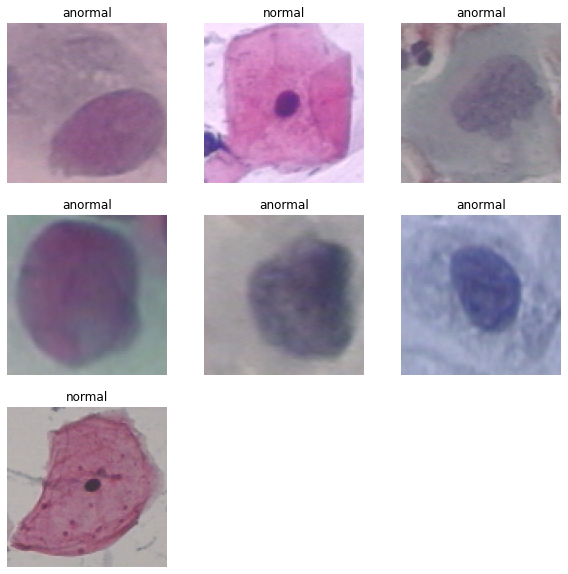

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(7):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip(input_shape=IMG_SHAPE),
    tf.keras.layers.RandomRotation(0.9, fill_mode="constant"),
    tf.keras.layers.RandomZoom(0.3, fill_mode="constant"),
    tf.keras.layers.RandomContrast(0.5)
  ]
)

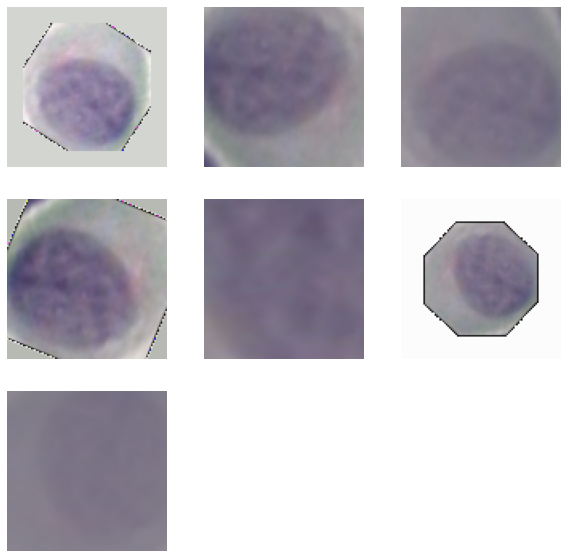

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(7):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
base_model = tf.keras.applications.ResNet152(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [14]:
NEURONS = 1024
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

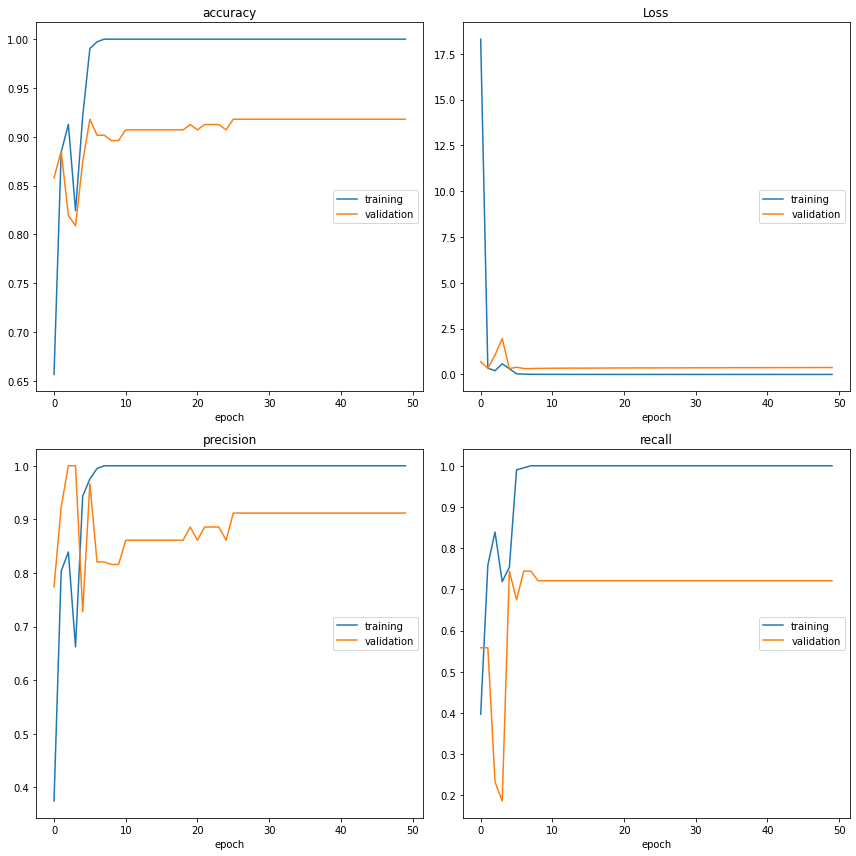

accuracy
	training         	 (min:    0.657, max:    1.000, cur:    1.000)
	validation       	 (min:    0.809, max:    0.918, cur:    0.918)
Loss
	training         	 (min:    0.000, max:   18.297, cur:    0.000)
	validation       	 (min:    0.317, max:    1.958, cur:    0.378)
precision
	training         	 (min:    0.374, max:    1.000, cur:    1.000)
	validation       	 (min:    0.727, max:    1.000, cur:    0.912)
recall
	training         	 (min:    0.397, max:    1.000, cur:    1.000)
	validation       	 (min:    0.186, max:    0.744, cur:    0.721)


In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS
)

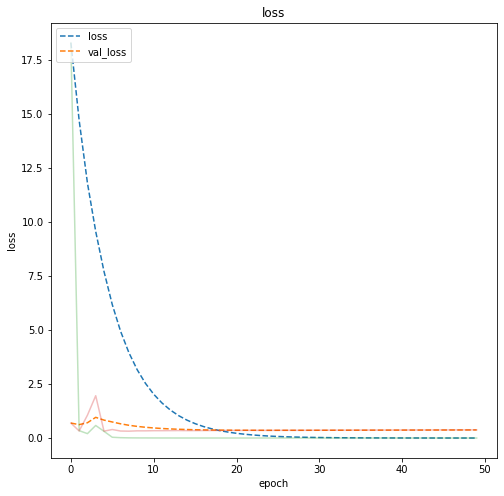

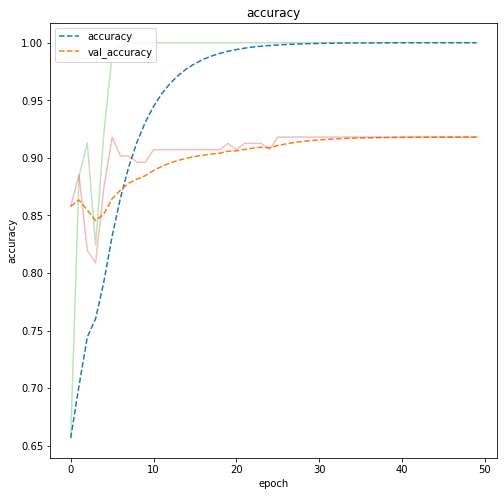

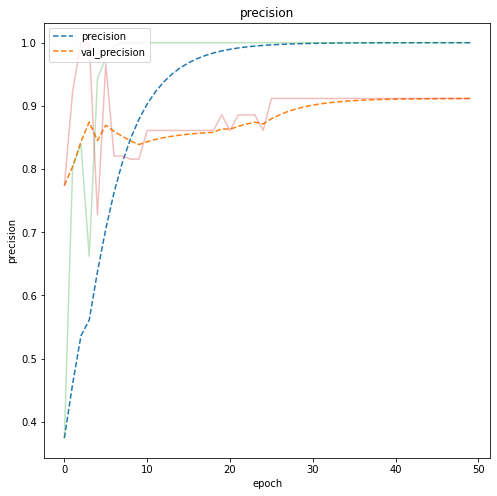

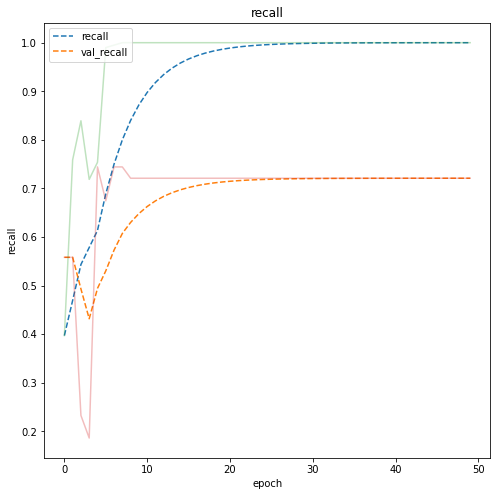

In [17]:
plot_metrics(history, metrics=['loss', 'accuracy', 'precision', 'recall'] , smooth=True)

In [18]:
evaluations = model.evaluate(val_ds, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 0.37823060154914856
accuracy: 0.9180327653884888
precision: 0.9117646813392639
recall: 0.7209302186965942
